In [62]:
# pull hrrr model data in zarr format from AWS S3
# example source: https://mesowest.utah.edu/html/hrrr/
# AWS S3 bucket: https://hrrrzarr.s3.amazonaws.com/index.html#sfc/
import xarray
# import rioxarray as rxr
import rasterio as rio
# import salem
import s3fs
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import datetime

In [63]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path): 
        return s3fs.S3Map(path, s3=s3) 

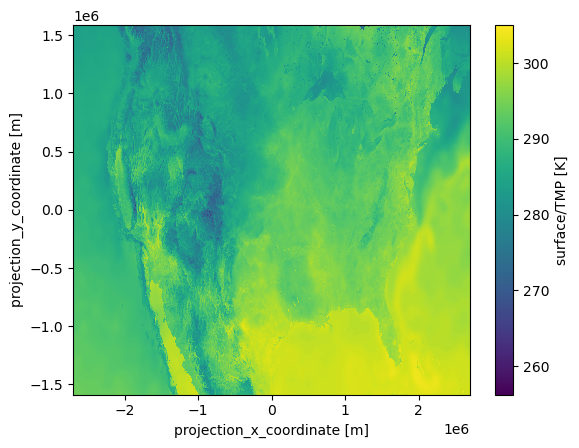

In [64]:
path = "hrrrzarr/sfc/20240603/20240603_12z_anl.zarr/surface/TMP" 
ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr", decode_coords="all") 
ds.TMP.plot()

In [65]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
    pressure                 float64 8B ...
    time                     datetime64[ns] 8B ...

In [66]:
# assign the time variable to be a dimension.
ds2 = ds.expand_dims(time=[ds.time.data])
ds2

<xarray.Dataset> Size: 4MB
Dimensions:                  (time: 1, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2024-06-03T12:00:00
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 8B 00:00:00
    forecast_reference_time  (time) datetime64[ns] 8B 2024-06-03T12:00:00
    height                   (time) float64 8B 1e+03
    pressure                 (time) float64 8B 2.5e+04

In [67]:
projection = ccrs.LambertConformal( central_longitude = -97.5, 
                                   central_latitude = 38.5, 
                                   standard_parallels = (38.5,38.5), 
                                   cutoff = 0)
# Write the CRS to the dataset
ds3 = ds2.rio.write_crs(projection, inplace=True)

# rename the x and y dimensions to lon and lat
ds3 = ds3.rename({'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})


Text(0.5, 1.0, 'HRRR Temperature (K) at 2024-06-03 12:00 UTC')

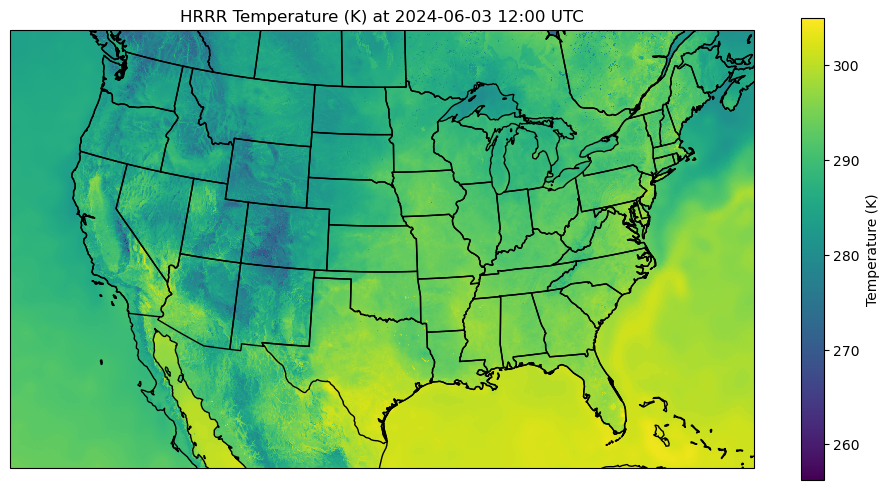

In [69]:
# plot ds4 as quadmesh with colorbar
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=projection)
ds3.TMP.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
# ds3.TMP.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('50m'))
plt.title(f'HRRR Temperature (K) at {pd.to_datetime(ds3.time.data[0]).strftime('%Y-%m-%d %H:%M')} UTC')
# plt.show()


In [71]:
# get 1 days worth of data starting today - 4 hours and lookback 6 hours. Convert from system clock to UTC.

endDate = datetime.datetime.now().astimezone(datetime.timezone.utc)
endDate = endDate - datetime.timedelta(hours=4)
lookbackHours = 6
startDate = endDate - datetime.timedelta(hours=lookbackHours)

# get the data "hrrrzarr/sfc/{%Y%m%d}/{%Y%m%d}_{hh}z_fcst.zarr/surface/TMP"
paths = []
for date in range(lookbackHours):
    date = startDate + datetime.timedelta(hours=date)
    path = f"hrrrzarr/sfc/{date:%Y%m%d}/{date:%Y%m%d}_{date:%H}z_anl.zarr/surface/TMP"
    paths.append(path)
paths

['hrrrzarr/sfc/20240718/20240718_05z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_06z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_07z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_08z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_09z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_10z_anl.zarr/surface/TMP']

In [72]:
# load the first dataset
ds1 = xarray.open_mfdataset([lookup(paths[0]), lookup(f"{paths[0]}/surface")], engine="zarr")
# make time a coordinate
ds1 = ds1.expand_dims(time=[ds1.time.data])
# merge the rest of the datasets
for path in paths[1:]:
    # get the time value
    print(path)
    ds2 = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr")
    ds2 = ds2.expand_dims(time=[ds2.time.data])
    ds1 = xarray.concat([ds1, ds2], dim="time")
ds1


hrrrzarr/sfc/20240718/20240718_06z_anl.zarr/surface/TMP
hrrrzarr/sfc/20240718/20240718_07z_anl.zarr/surface/TMP
hrrrzarr/sfc/20240718/20240718_08z_anl.zarr/surface/TMP
hrrrzarr/sfc/20240718/20240718_09z_anl.zarr/surface/TMP
hrrrzarr/sfc/20240718/20240718_10z_anl.zarr/surface/TMP


<xarray.Dataset> Size: 23MB
Dimensions:                  (time: 6, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 48B 2024-07-18T05:00:00 .....
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 23MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 48B 00:00:00 ... 00:00:00
    forecast_reference_time  (time) datetime64[ns] 48B 2024-07-18T05:00:00 .....
    height                   (time) float64 48B 1e+03 1e+03 ... 1e+03 1e+03
    pressure                 (time) float64 48B 2.5e+04 2.5e+04 ... 2.5e+04

In [73]:
projection = ccrs.LambertConformal( central_longitude = -97.5, 
                                   central_latitude = 38.5, 
                                   standard_parallels = (38.5,38.5), 
                                   cutoff = 0)
# Write the CRS to the dataset
ds1 = ds1.rio.write_crs(projection, inplace=True)

# rename the x and y dimensions to lon and lat
ds1 = ds1.rename({'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})

In [74]:
ds1

<xarray.Dataset> Size: 23MB
Dimensions:                  (time: 6, y: 1059, x: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 48B 2024-07-18T05:00:00 .....
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
    spatial_ref              int64 8B 0
Data variables:
    TMP                      (time, y, x) float16 23MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 48B 00:00:00 ... 00:00:00
    forecast_reference_time  (time) datetime64[ns] 48B 2024-07-18T05:00:00 .....
    height                   (time) float64 48B 1e+03 1e+03 ... 1e+03 1e+03
    pressure                 (time) float64 48B 2.5e+04 2.5e+04 ... 2.5e+04

Text(0.5, 1.0, 'HRRR Temperature (K) at 2024-06-03 12:00 UTC')

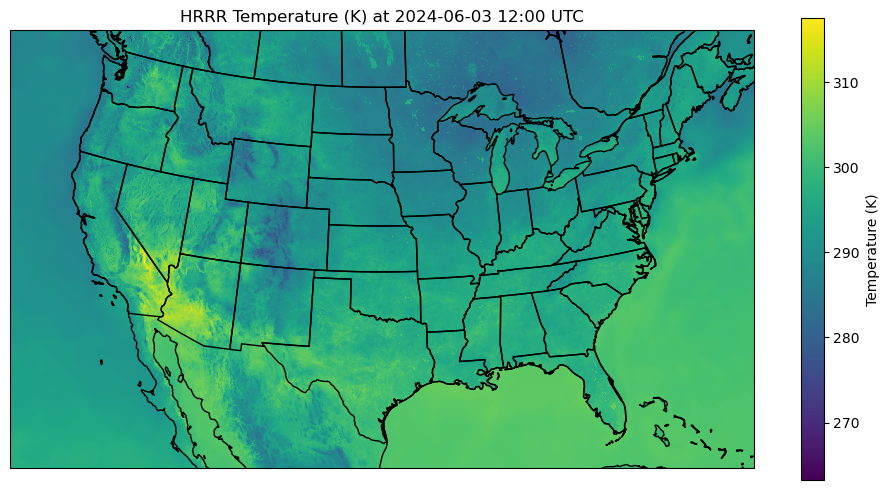

In [76]:
# plot ds1 as quadmesh with colorbar
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=projection)
ds1.TMP.isel(time = 0).plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
# ds3.TMP.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('50m'))
plt.title(f'HRRR Temperature (K) at {pd.to_datetime(ds3.time.data[0]).strftime('%Y-%m-%d %H:%M')} UTC')

In [81]:
ds1.time.data

array(['2024-07-18T05:00:00.000000000', '2024-07-18T06:00:00.000000000',
       '2024-07-18T07:00:00.000000000', '2024-07-18T08:00:00.000000000',
       '2024-07-18T09:00:00.000000000', '2024-07-18T10:00:00.000000000'],
      dtype='datetime64[ns]')

In [114]:
def animate(i): 
	# z = np.ma.masked_array(ds["APCP_surface"].isel(time=i), ds["APCP_surface"].isel(time=i) < .01) 
	# z = np.ma.masked_invalid(z) 
	# cax.set_array(ds["APCP_surface"].isel(time=i)) 
	# t = pd.to_datetime(str(ds["time"].isel(time=i).values)).strftime('%Y-%m-%d %H:%M') 
	# fig.suptitle(f'Precipitation (mm) {t}') 
    # ds1.TMP.isel(time = i).plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
    ds1.TMP.isel(time = i).plot(ax=ax, add_colorbar=False, cmap='turbo')
    # ds1.TMP.isel(time = i).plot.imshow(ax=ax, animated=True)
    plt.title(f'HRRR Temperature (K) at {pd.to_datetime(ds1.time.data[i]).strftime('%Y-%m-%d %H:%M')} UTC')
    # add a buffer between the title and the plot
    plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
fig, ax = plt.subplots(figsize=(12, 6))
ax = plt.axes(projection=projection)
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('50m'))	
# add a colorbar
mld = ds1.TMP.isel(time=0).plot(ax=ax, add_colorbar= False, cmap='turbo')
cbar = fig.colorbar(mld)
# add label to colorbar
cbar.set_label('Temperature (K)')
# add padding
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# create an animation
anim = animation.FuncAnimation(fig, animate, interval=1000, frames=range(0, len(ds1["time"]))) 
anim.save('hrrr.mp4', writer='ffmpeg')
HTML(anim.to_jshtml())
